# Sampling Methods

## Sampling is difficult.

A general sampling method I can think of.

- find CDF by integrating PDF from $-\infty$ to x.
- find inverse function of CDF.
- take a sample from uniform distribution and put the value in the function found.

![sampling_by_inverse_cdf](images/standard_normal_pdf_cdf.png)

It's more difficult when it comes to high dimensions.

### If it was easy it would have been great

If it were easy to sample always, we could easily find global maximum
$$\max_x f(x)$$
just by taking samples from $$\lim_{K \to \infty}e^{Kf(x)}$$.

(Frequently, PDF we have is not normalized.)

#### for example

$$
f(x) = -(x-1)^2(x+1)^2 + 1 + 0.05x^3
$$

$$
e^{Kf(x)} = e^{K(-(x-1)^2(x+1)^2 + 1 + 0.05x^3)}
$$

| $K = 1$  | $K = 5$  | $K = 10$|
| -------- | -------- | ------- |
|![global maximum K=1](./images/global_maximum_k1.png)|![global maximum K=5](./images/global_maximum_k5.png)|![global maximum K=10](./images/global_maximum_k10.png)|

## Sampling is useful
We can calculate expectation values by sampling.

$$\int f(x)p(x) dx \approx \sum_{i=1}^{N} {f(X_i) \over N} $$

## Naive sampling

In [1]:
import numpy as np
import seaborn as sns
import math
from scipy.stats import multivariate_normal

In [2]:
def easy_p(x):
    mean1 = np.array([1, 1])
    cov1 = np.array([[1, 0], [0, 1]])
    mean2 = np.array([3, 4])
    cov2 = np.array([[1, 0], [0, 1]])
    return (4 * multivariate_normal.pdf(x, mean=mean1, cov=cov1) + 1 * multivariate_normal.pdf(x, mean=mean2, cov=cov2))/5

(1500, 2)


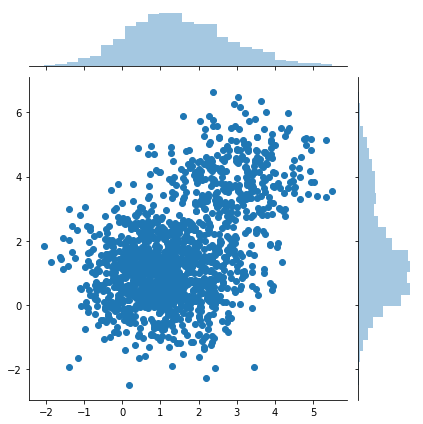

In [9]:
def naive_sample_from_easy_p(iter):
    mean1 = np.array([1, 1])
    cov1 = np.array([[1, 0], [0, 1]])
    mean2 = np.array([3, 4])
    cov2 = np.array([[1, 0], [0, 1]])
    samples = np.zeros((iter, 2))
    for i in range(iter):
        if np.random.rand() < 4/5:
            x_star = multivariate_normal.rvs(mean=mean1, cov=cov1)
        else:
            x_star = multivariate_normal.rvs(mean=mean2, cov=cov2)
        samples[i] = x_star
    return np.array(samples)

samples = naive_sample_from_easy_p(1500)
sns.jointplot(samples[:, 0], samples[:, 1])
print(samples.shape)

## Rejection sampling

In [4]:
def difficult_and_not_normalized_p(x):
    rSquare = (x[0]-2)**2 + (x[1]-3)**2
    return 0 if rSquare > 3**2 else easy_p(x)

(760, 2)


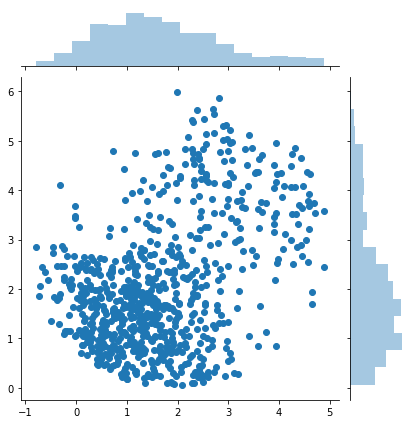

In [5]:
def rejection_sample(f, iter):
    proposal_mean = np.array([2.1, 3.1])
    proposal_cov = np.array([[3, 0],[0, 3]])
    samples = []
    m = 10
    for i in range(iter):
        x_star = multivariate_normal.rvs(mean = proposal_mean, cov = proposal_cov)
        criteria = f(x_star)/(m * multivariate_normal.pdf(x_star, mean = proposal_mean, cov = proposal_cov))
        if criteria > 1:
            # proposal distribution is not enveloping the target distribution
            # increase m
            print(criteria)
        elif np.random.rand() < criteria:
            samples.append(x_star)
    return np.array(samples)

samples = rejection_sample(difficult_and_not_normalized_p, 10000)
sns.jointplot(samples[:, 0], samples[:, 1])
print(samples.shape)

![rejection sampling criterion](images/rejection_sampling_criterion.png)

(79, 2)


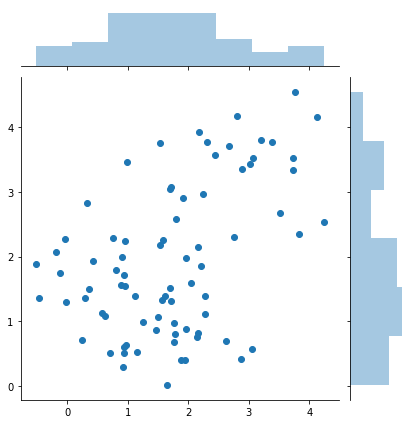

In [6]:
def rejection_sample(f, iter):
    proposal_mean = np.array([3, 3])
    proposal_cov = np.array([[1, 0],[0, 1]])
    samples = []
    m = 500
    for i in range(iter):
        x_star = multivariate_normal.rvs(mean = proposal_mean, cov = proposal_cov)
        criteria = f(x_star)/(m * multivariate_normal.pdf(x_star, mean = proposal_mean, cov = proposal_cov))
        if criteria > 1:
            # proposal distribution is not enveloping the target distribution
            # increase m
            print(criteria)
        elif np.random.rand() < criteria:
            samples.append(x_star)
    return np.array(samples)

samples = rejection_sample(difficult_and_not_normalized_p, 50000)
sns.jointplot(samples[:, 0], samples[:, 1])
print(samples.shape)

## Relationship of sampling methods

![sampling methods](images/sampling_methods_diagram.png)

## Metropolis-Hastings algorithm

(2000, 2)


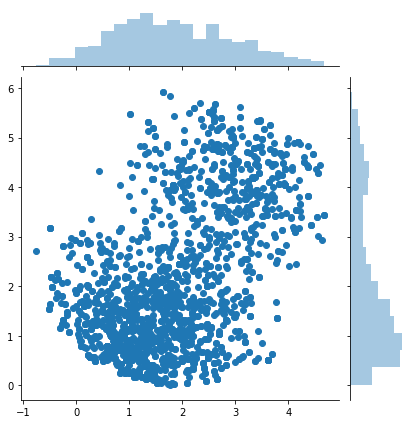

In [8]:
def metropolis_hastings(f, iter):
    x = np.array([4., 1.])
    proposal_cov = np.array([[0.5, 0],[0, 0.5]])
    burn_in = 200
    samples = np.zeros((iter, 2))

    for i in range(iter + burn_in):
        x_star = multivariate_normal.rvs(mean=x, cov=proposal_cov)

        a = f(x_star) / f(x)
        # can be skipped since it's symmetric (That's all about the Metropolis algorithm.)
        a *= multivariate_normal.pdf(x, mean=x_star, cov=proposal_cov) / multivariate_normal.pdf(x_star, mean=x, cov=proposal_cov)

        if np.random.rand() < a:
            x = x_star
        if i >= burn_in:
            samples[i - burn_in] = x
    return samples

samples = metropolis_hastings(difficult_and_not_normalized_p, 2000)
sns.jointplot(samples[:, 0], samples[:, 1])
print(samples.shape)

![metropolis hastings illustration](images/mh_explained.png)
![metropolis hastings proposals](images/mh_proposals.png)

### About Markov chain

Try it!

http://markov.yoriz.co.uk/

### To be a good Markov chain to sample from

![mc properties](images/mc_properties.png)


- A circle is a property of a state.
- A box is a property of a Markov chain.

### Derivation of MH algorithm

#### Goal

Design a markov chain that has a stationary distribution $\pi(x) = P(x)$ and the stationary distribution is unique.

#### How?

##### Propose transition(conditional) probabilities

$P(x'|x_t) = g(x'|x_t) \cdot A(x',x_t)$

- $g(x'|x_t)$ is any proposal distribution chosen.
- $A(x',x_t)=\min \left(1,{\frac {P(x')}{P(x_{t})}}{\frac {g(x_{t}|x')}{g(x'|x_{t})}}\right)$ is acceptance probability.

##### Show that the markov chain is reversible.

proof.

Because either $A(x',x)$ or $A(x',x)$ will be 1, the equation below holds.

$$
{\frac {A(x',x)}{A(x,x')}}={\frac {P(x')}{P(x)}}{\frac {g(x|x')}{g(x'|x)}}
$$


By multiplying denominators and the both side of equation, we have

$$
g(x'|x_t) \cdot A(x',x_t) = g(x_t, x') \cdot A(x_t, x')
$$.

Then,

$$
P(x'|x)P(x) = P(x|x')P(x')
$$.

Now we showed the detailed balance property for each transition probability.

So, by definition, the markov chain is reversible, thus, it has a stationary distribution.

##### Show that it is also ergodic.

I couldn't find the proof, but they looks trivial for the markov chain with discrete states.

- The markov chain we made is positive recurrent.
  - The expected return time of state $i$ is finite.
- The markov chain we made is aperiodic.
  - We can make infinitely many paths returning to the same state that the number of steps is not periodic with any positive integer which is non zero.

By definition it is ergodic.

## References

- https://www.youtube.com/playlist?list=PLD0F06AA0D2E8FFBA
- http://www.secmem.org/blog/2019/01/11/mcmc/
- http://markov.yoriz.co.uk/
- https://en.wikipedia.org/wiki/Markov_chain
- https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm
- https://en.wikipedia.org/wiki/Gibbs_sampling
- https://stats.stackexchange.com/questions/185631/what-is-the-difference-between-metropolis-hastings-gibbs-importance-and-rejec
- https://www.youtube.com/playlist?list=PLt9QR0WkC4WVszuogbmIIHIIQ2RMI78RC
- https://brilliant.org/wiki/stationary-distributions/
- https://brilliant.org/wiki/ergodic-markov-chains/
- https://www.researchgate.net/figure/Illustration-of-Metropolis-Hastings-M-H-algorithm-explained-in-Figure-1_fig8_279248766

## Appendix

```graphviz
digraph {
    # nodes
    sAccesible [label=accessible]
    sComunicate [label=communicate]
    cIreducible [label=irreducible, shape=box]

    sAperiodic [label=aperiodic]
    sRecurrent [label="positive recurrent"]
    sErgodic [label=ergodic]
    cErgodic [label=ergodic, shape=box, fillcolor=gray, style=filled]

    sDetailedBalance [label="detailed balance"]
    cReversible [label=reversible, shape=box, fillcolor=gray, style=filled]
    cStationaryDistribution [label="has stationary distribution", shape=box]
    cUniquePositiveStationaryDistribution [label="has unique positive stationary distribution", shape=box, fillcolor=lightblue, style=filled]
    
    and [label="+", shape=circle]

    # edges
    cIreducible -> sComunicate -> sAccesible
    sErgodic -> sAperiodic
    sErgodic -> sRecurrent
    cErgodic -> sErgodic
    cErgodic -> cIreducible
    cReversible -> sDetailedBalance
    cReversible -> cStationaryDistribution
    cReversible -> cIreducible
    
    cErgodic -> and [style=dashed]
    cStationaryDistribution -> and [style=dashed]
    and -> cUniquePositiveStationaryDistribution
}
```